# Comparing centrality measures in Estonian and English Wikipedias

## Setup

In [1]:
!pip install -q networkx

In [2]:
import pandas as pd
import networkx as nx
import heapq
from multiprocessing import Pool
import seaborn as sns


## Read data

In [3]:
def filter_categories(data: pd.DataFrame) -> pd.DataFrame:
    return data[~data["node_name"].str.startswith("Category:")]

In [4]:
edges_en = pd.read_csv("../data/edges_en.csv")
edges_et = pd.read_csv("../data/edges_et.csv")
nodes_en = filter_categories(pd.read_csv("../data/nodes_en.csv"))
nodes_et = filter_categories(pd.read_csv("../data/nodes_et.csv"))
nodes_en

,node_id,node_name,node_summary,node_et_equivalent
0,27685,Tantra,Tantra (; ) refers to an esoteric yogic tr...,Tantrad
1,911,African Americans in Tennessee,African Americans are the second largest ethni...,NaN
2,3359,Asia Minor,NaN,NaN
3,13296,Hot in Cleveland (season 5),The fifth season of the TV Land original sitco...,NaN
4,6720,Christopher Duggan,Christopher John Hesketh Duggan (4 November 19...,NaN
...,...,...,...,...
31816,7475,Cormac Burke (priest),NaN,NaN
31817,30894,Western world,"The Western world, also known as the West, pri...",Läänemaailm
31818,13108,History of the Hungarian language,"right|thumb|250px|The ""Funeral Sermon and Pray...",NaN
31819,140,1996 Nobel Prize in Literature,The 1996 Nobel Prize in Literature was awarded...,NaN


In [5]:
edges_en

,source,target
0,22260,150
1,22260,264
2,22260,266
3,22260,402
4,22260,460
...,...,...
69144,5237,6054
69145,5237,6064
69146,5237,6125
69147,5237,22836


## Construct graphs

In [6]:
def create_graph(nodes: pd.DataFrame, edges: pd.DataFrame) -> nx.Graph:
    n = nodes.drop_duplicates(subset='node_id').reset_index(drop=True)
    g = nx.from_pandas_edgelist(edges, create_using=nx.Graph())
    node_attrs = n.set_index('node_id').to_dict('index')
    nx.set_node_attributes(g, node_attrs)
    return g


In [7]:
g_en = create_graph(nodes_en, edges_en)
g_et = create_graph(nodes_et, edges_et)

g_en.nodes[27685]

{'node_name': 'Tantra',
 'node_summary': '   Tantra (; ) refers to an  esoteric yogic tradition that developed on the Indian subcontinent from the middle of the 1st millennium CE onwards in both Hinduism and Buddhism.  The term tantra, in the Indian traditions, also means any systematic broadly applicable "text, theory, system, method, instrument, technique or practice".  A key feature of these traditions is the use of mantras, and thus they are commonly referred to as Mantramārga ("Path of Mantra") in Hinduism or Mantrayāna ("Mantra Vehi.',
 'node_et_equivalent': 'Tantrad'}

## Compute centrality metrics

In [8]:
pagerank_en_scores = nx.pagerank(g_en)
heapq.nlargest(10, pagerank_en_scores, key=pagerank_en_scores.get)

[2386, 4305, 3148, 3569, 2131, 4481, 1108, 1412, 988, 4938]

In [14]:
from typing import Tuple, Dict
import time

def _compute_and_time(func, args):
    start_time = time.time()
    result = func(*args)
    return result, time.time() - start_time

def compute_centrality_measures_and_execution_times(g: nx.Graph) -> Tuple[pd.DataFrame, Dict[str, float]]:

    degree, degree_time = _compute_and_time(nx.degree_centrality, (g,))
    print("Degree finished")
    
    betweenness, betweenness_time = _compute_and_time(nx.betweenness_centrality, (g,))
    print("Betweenness finished")

    eigenvector, eigenvector_time = _compute_and_time(nx.eigenvector_centrality, (g,))
    print("Eigenvector finished")

    closeness, closeness_time = _compute_and_time(nx.closeness_centrality, (g,))
    print("Closeness finished")

    pagerank, pagerank_time = _compute_and_time(nx.pagerank, (g,))
    print("Pagerank finished")

    return pd.DataFrame.from_dict({
        "degree": degree,
        "betweenness": betweenness,
        "eigenvector": eigenvector,
        "closeness": closeness,
        "pagerank": pagerank
    }), {
        "degree": degree_time,
        "betweenness": betweenness_time,
        "eigenvector": eigenvector_time,
        "closeness": closeness_time,
        "pagerank": pagerank_time
    }


In [9]:

def compute_centrality_measures(g: nx.Graph) -> pd.DataFrame:
    with Pool() as pool:
        degree = pool.apply_async(nx.degree_centrality, (g,))
        betweenness = pool.apply_async(nx.betweenness_centrality, (g,))
        eigenvector = pool.apply_async(nx.eigenvector_centrality, (g,))
        closeness = pool.apply_async(nx.closeness_centrality, (g,))
        pagerank = pool.apply_async(nx.pagerank, (g,))

        return pd.DataFrame.from_dict({
            "degree": degree.get(),
            "betweenness": betweenness.get(),
            "eigenvector": eigenvector.get(),
            "closeness": closeness.get(),
            "pagerank": pagerank.get()
        })

In [15]:
centrality_et, centrality_et_times = compute_centrality_measures_and_execution_times(g_et)

Degree finished
Betweenness finished
Eigenvector finished
Closeness finished
Pagerank finished


In [17]:
centrality_et

,degree,betweenness,eigenvector,closeness,pagerank
2290,0.031655,0.171528,0.204105,0.508041,0.007244
596,0.001870,0.000000,0.044752,0.350253,0.000378
769,0.000134,0.000000,0.004761,0.336903,0.000046
915,0.000134,0.000000,0.004761,0.336903,0.000046
976,0.000267,0.000000,0.008634,0.339562,0.000073
...,...,...,...,...,...
7401,0.000134,0.000000,0.001255,0.279241,0.000053
7403,0.000134,0.000000,0.001255,0.279241,0.000053
7014,0.000134,0.000000,0.001255,0.279241,0.000053
4031,0.000134,0.000000,0.000695,0.269413,0.000047


In [18]:
centrality_et_times

{'degree': 0.005384922027587891,
 'betweenness': 139.5327320098877,
 'eigenvector': 0.3008558750152588,
 'closeness': 11.701691389083862,
 'pagerank': 0.023215055465698242}

In [19]:
centrality_en, centrality_en_times = compute_centrality_measures_and_execution_times(g_en)

Degree finished
Betweenness finished
Eigenvector finished
Closeness finished
Pagerank finished


In [ ]:
centrality_et = compute_centrality_measures_and_execution_times(g_et)

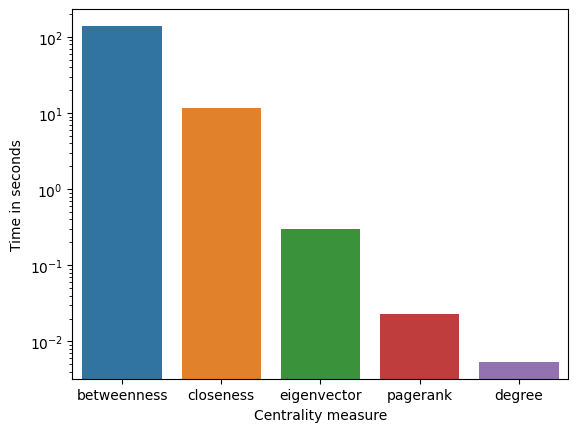

In [29]:
import matplotlib.pyplot as plt

sns.barplot(data=pd.DataFrame.from_dict(
    centrality_et_times, orient='index',
    columns=['time'])\
    .reset_index()\
    .rename(columns={'index': 'measure'})
    .sort_values(by="time", ascending=False),
    x="measure",
    y="time"
            )
plt.ylabel('Time in seconds')
plt.xlabel('Centrality measure')
plt.yscale('log')

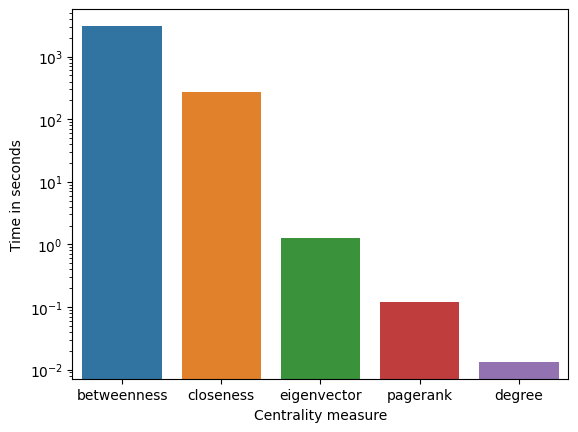

In [30]:
sns.barplot(data=pd.DataFrame.from_dict(
    centrality_en_times, orient='index',
    columns=['time'])\
    .reset_index()\
    .rename(columns={'index': 'measure'})
    .sort_values(by="time", ascending=False),
    x="measure",
    y="time"
            )
plt.ylabel('Time in seconds')
plt.xlabel('Centrality measure')
plt.yscale('log')

In [50]:
centrality_et

,degree,betweenness,eigenvector,closeness,pagerank
2290,0.031655,0.171528,0.204105,0.508041,0.007244
596,0.001870,0.000000,0.044752,0.350253,0.000378
769,0.000134,0.000000,0.004761,0.336903,0.000046
915,0.000134,0.000000,0.004761,0.336903,0.000046
976,0.000267,0.000000,0.008634,0.339562,0.000073
...,...,...,...,...,...
7401,0.000134,0.000000,0.001255,0.279241,0.000053
7403,0.000134,0.000000,0.001255,0.279241,0.000053
7014,0.000134,0.000000,0.001255,0.279241,0.000053
4031,0.000134,0.000000,0.000695,0.269413,0.000047


In [39]:
centrality_en

,degree,betweenness,eigenvector,closeness,pagerank
22260,0.029199,0.072744,0.152093,0.507408,0.005038
150,0.013735,0.003669,0.111759,0.378492,0.002045
264,0.000031,0.000000,0.001381,0.336613,0.000009
266,0.000031,0.000000,0.001381,0.336613,0.000009
402,0.024453,0.010613,0.029055,0.349216,0.003941
...,...,...,...,...,...
31774,0.000031,0.000000,0.001378,0.283843,0.000009
31775,0.000031,0.000000,0.001378,0.283843,0.000009
30959,0.000031,0.000000,0.001378,0.283843,0.000009
5852,0.000031,0.000000,0.001378,0.283843,0.000009


In [51]:
centrality_en.to_csv("../data/centrality_en.csv")
centrality_et.to_csv("../data/centrality_et.csv")

In [10]:
synthetically_central_nodes_en = ['Philosophy', '19th-century philosophy', 'Abhidharma', 'Absolute idealism', 'Academic skepticism', 'Accident (philosophy)', 'Achintya Bheda Abheda', 'Action (philosophy)', 'Action theory (philosophy)', 'Adharma', 'Adi Shankara', 'Advaita Vedanta', 'Aesthetic emotions', 'Aesthetics', 'African-American literature', 'African diaspora', 'African feminism', 'African philosophy', 'Africana philosophy', 'Afterlife', 'Agriculturalism', 'Ahimsa in Jainism', 'Ajñana', 'Akasha', 'Akhenaten', 'Akkadian language', 'Al-Biruni', 'Al-Ghazali', 'Al-Kindi', 'Alan Bullock', 'Alex Trebek', 'Alf Hiltebeitel', 'Algonquian languages', 'American philosophy', 'Amun', 'Analects', 'Analytic philosophy', 'Analytical Marxism', 'Analytical feminism', 'Anarchism', 'Ancient Egypt', 'Ancient Egyptian conception of the soul', 'Ancient Egyptian philosophy', 'Ancient Greece', 'Ancient Greek', 'Ancient Greek architecture', 'Ancient Greek philosophy', 'Ancient Roman philosophy', 'Ancient Rome', 'Ancient philosophy', 'Andrew Louth', 'Anekantavada', 'Anselm of Laon', 'Anthony Kenny', 'Anthony Quinton', 'Anthropology', 'Anti-realism', 'Antihumanism', 'Anton Wilhelm Amo', 'Applied ethics', 'Applied philosophy', 'Aquiauhtzin', 'Arab world', 'Arabic', 'Arete of Cyrene', 'Aristotelianism', 'Aristotle', 'Art', 'Assyriology', 'Astronomy', 'Aten', 'Atenism', 'Atomism', 'Augustine of Hippo', 'Augustinianism', 'Australian philosophy', 'Averroes', 'Averroism', 'Avicenna', 'Avicennism', 'Avidyā (Buddhism)', 'Aztec philosophy', 'Babylonia', 'Bantu Philosophy', 'Beauty', 'Behaviorism', 'Belief', 'Bell hooks', 'Bertrand Russell', 'Bhedabheda', 'Biology', 'Black existentialism', 'Boethius', 'Brahman', 'British idealism', 'British philosophy', 'Buddhism', 'Buddhist logico-epistemology', 'Buddhist meditation', 'Buddhist philosophy']

synthetically_central_nodes_et = [['Filosoofia', '19. sajand', '1980', '20. sajand', 'Aasia', 'Ajafilosoofia', 'Ajaloofilosoofia', 'Aksioloogia', 'Analüütiline filosoofia', 'Anaximandros', 'Anaximenes', 'Antiikfilosoofia', 'Aquino Thomas', 'Aristoteles', 'Armastus', 'Arthur Schopenhauer', 'Astronoomia', 'Augustinus', 'Aurobindo', 'Averroes', 'Baruch Spinoza', 'Bertrand Russell', 'Bioloogia', 'David Hume', 'Definitsioon', 'Demokritos', 'Diogenes Laertios', 'Edmund Husserl', 'Eesti filosoofia', 'Eesti filosoofide loend', 'Eesti keel', 'Eetika', 'Eksistentsialism', 'Epistemoloogia', 'Ese', 'Esteetika', 'Ettekujutus', 'Filosoof', 'Filosoofia (õppeaine)', 'Filosoofia ajalugu', 'Filosoofia mõisteid', 'Filosoofia valdkonnad', 'Filosoofiline küsimus', 'Filosoofiline loogika', 'Filosoofiline nõustamine', 'Filosoofiline probleem', 'Filosoofiliste teaduste entsüklopeedia', 'Filosoofiliste teoste loend', 'Francis Bacon', 'Friedrich Nietzsche', 'Füüsika', 'Geoloogia', 'Georg Wilhelm Friedrich Hegel', 'George Berkeley', 'Gottfried Wilhelm Leibniz', 'Gottlob Frege', 'Henri Bergson', 'Herakleitos', 'Hiina filosoofia', 'Hiina keel', 'Hinduistlik filosoofia', 'Ida filosoofia', 'Ilu', 'Immanuel Kant', 'India filosoofia', 'Jaapani filosoofia', 'Jaapani keel', 'Jacques Derrida', 'Jean-Jacques Rousseau', 'Jean-Paul Sartre', 'John Locke', 'John Rawls', 'John Stuart Mill', 'Jumal', 'Karl Marx', 'Keel', 'Keelefilosoofia', 'Keskaja filosoofia', 'Kong Fuzi', 'Kontinentaalfilosoofia', 'Korea keel', 'Kriitiline teooria', 'Kriminalistika', 'Kristlik filosoofia', 'Kunst', 'Laozi', 'Liitsõna', 'Loodus', 'Loodusfilosoofia', 'Loogika', 'Loogikute loend', 'Ludwig Wittgenstein', 'Luule', 'Läti filosoofia', 'Lääne filosoofia', 'Läänemaailm', 'Maailmavaade', 'Mahatma Gandhi', 'Martin Heidegger', 'Matemaatika']]

# centrality_en_cleaned = centrality_en[~centrality_en["node_name"].isin(synthetically_central_nodes_en)]

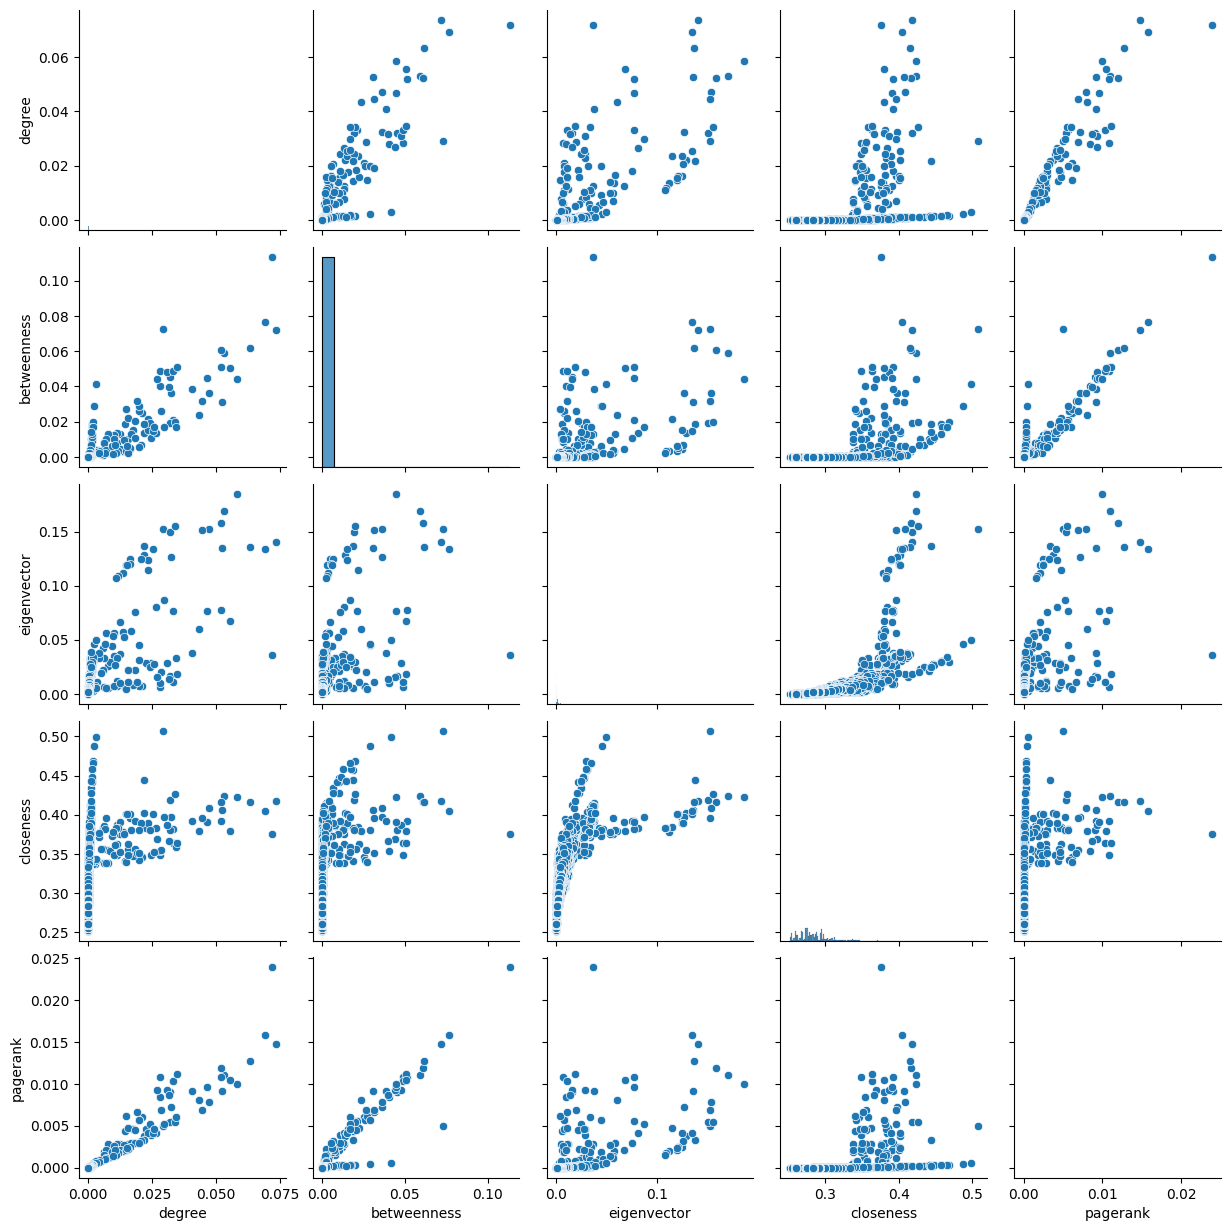

In [42]:
sns.pairplot(centrality_en);

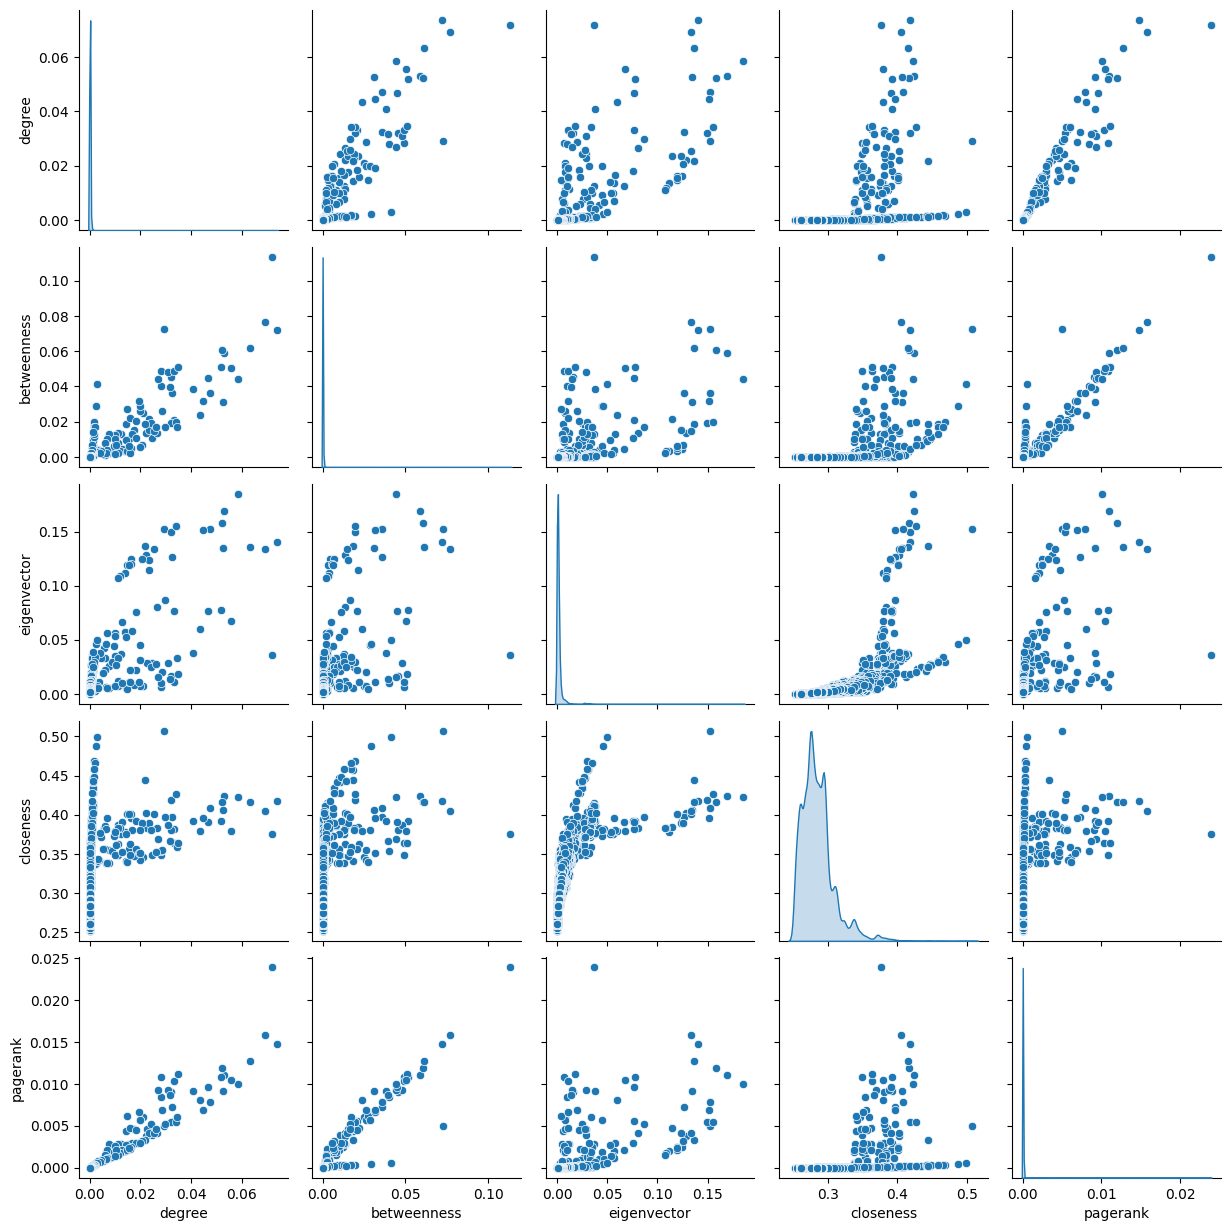

In [45]:
sns.pairplot(centrality_en, diag_kind="kde")

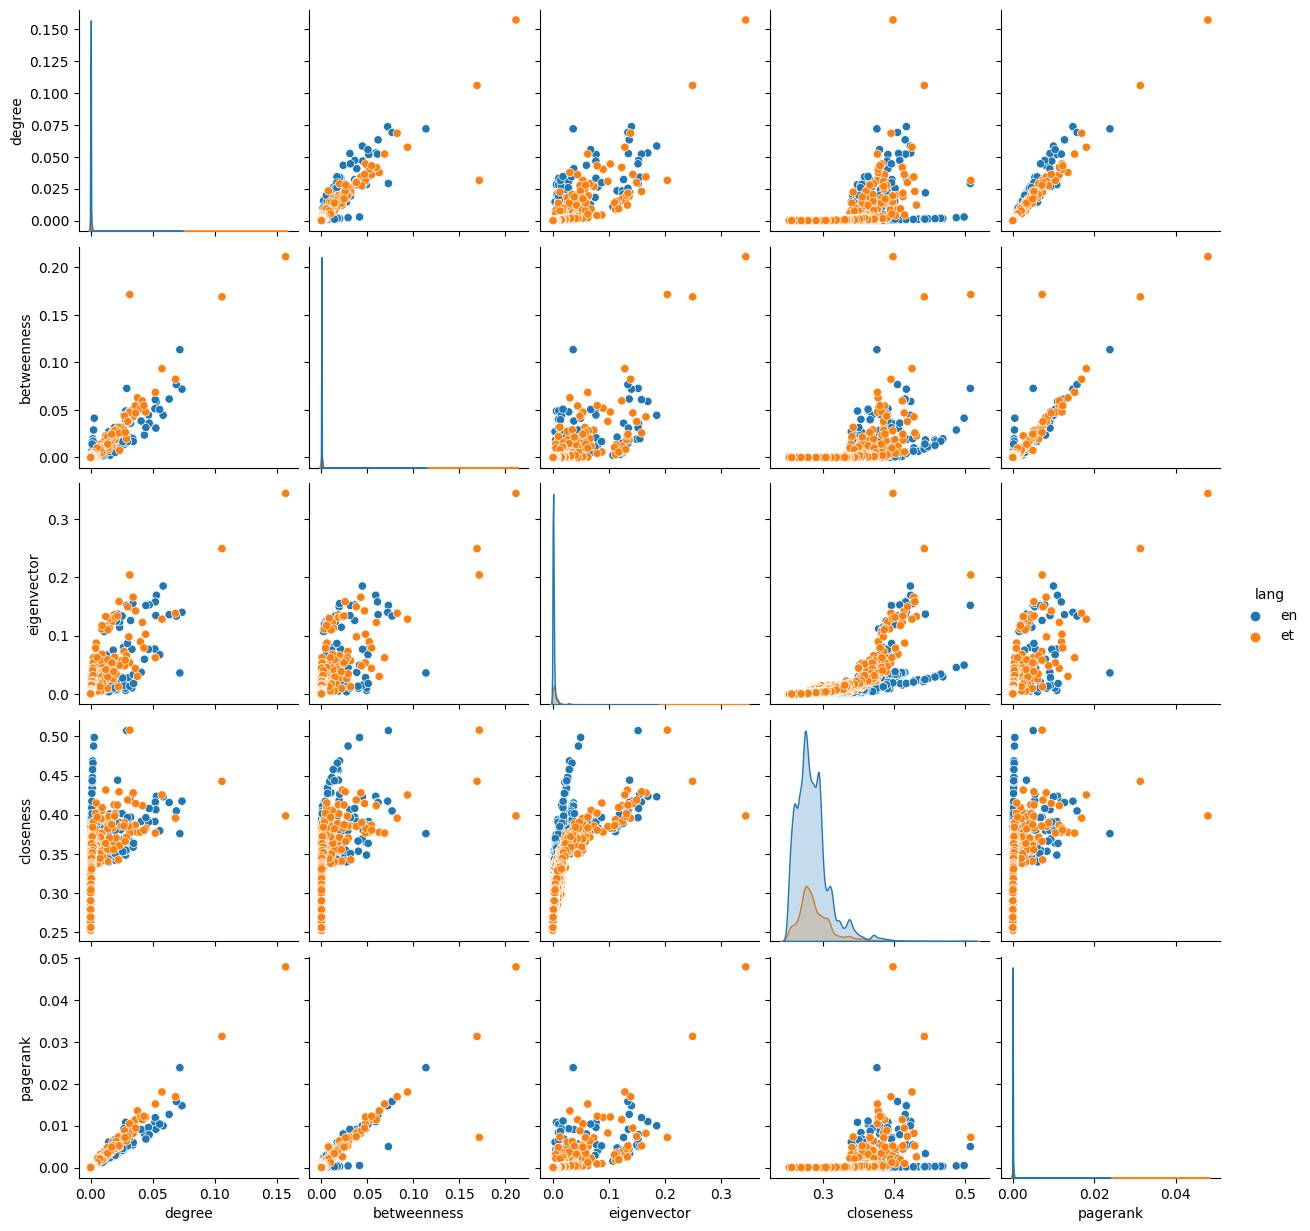

In [52]:
centrality_en_lang = centrality_en.copy()
centrality_et_lang = centrality_et.copy()

centrality_en_lang["lang"] = "en"
centrality_et_lang["lang"] = "et"

centrality_combined = pd.concat([centrality_en_lang, centrality_et_lang])

sns.pairplot(centrality_combined, diag_kind="kde", hue="lang")

In [6]:
centrality_en = pd.read_csv("../data/centrality_en.csv")
centrality_et = pd.read_csv("../data/centrality_et.csv")

def filter_categories(data: pd.DataFrame) -> pd.DataFrame:
    return data[~data["node_name"].str.startswith("Category:")]

nodes_en = filter_categories(pd.read_csv("../data/nodes_en.csv"))
nodes_et = filter_categories(pd.read_csv("../data/nodes_et.csv"))

nodes_et_with_centrality = pd.merge(nodes_et.set_index("node_id"), centrality_et, left_index=True, right_index=True)
nodes_en_with_centrality = pd.merge(nodes_en.set_index("node_id"), centrality_en, left_index=True, right_index=True)

In [7]:
nodes_et_with_centrality.sort_values("pagerank")["node_name"].head(10).tolist()

['Carl von Linné',
 'Carl Hempel',
 'Carl Jung',
 'Carl Rogers',
 'Ángelos Charistéas',
 'Ärieetika',
 'Äng',
 'École Normale Superieure',
 'Äärmus',
 'Zwiesprache']

In [8]:
import pandas as pd

def _get_top_n(nodes, measure, artificially_centric, n):
    values = nodes.sort_values(measure)["node_name"].tolist()
    return [v for v in values if not v in artificially_centric][:n]

def get_most_central_nodes_by_centrality_measure(nodes: pd.DataFrame, artificially_centric: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
            "degree": _get_top_n(nodes, "degree", artificially_centric, 10),
            "betweenness": _get_top_n(nodes, "betweenness", artificially_centric, 10),
            "eigenvector": _get_top_n(nodes, "eigenvector", artificially_centric, 10),
            "closeness": _get_top_n(nodes, "closeness", artificially_centric, 10),
            "pagerank": _get_top_n(nodes, "pagerank", artificially_centric, 10),
        })

def get_top_abstracts(nodes: pd.DataFrame, artificially_centric: pd.DataFrame) -> str:
    top_nodes = []
    for measure in ["degree", "betweenness", "eigenvector", "closeness", "pagerank"]:
        top_nodes.extend(_get_top_n(nodes, measure, artificially_centric, 100))
    top_abstracts = [nodes[nodes["node_name"] == name]["node_summary"].values[0] for name in top_nodes]
    return " ".join([t for t in top_abstracts if type(t) == str])

In [14]:
get_most_central_nodes_by_centrality_measure(nodes_en_with_centrality, synthetically_central_nodes_en)

,degree,betweenness,eigenvector,closeness,pagerank
0,Kitsch,Kitsch,"Other Minds: The Octopus, the Sea, and the Dee...","Other Minds: The Octopus, the Sea, and the Dee...","Tyre, Lebanon"
1,Ninurta-kudurri-usur II,Osorkon I,Ostrakon,Oswald de Andrade,Tír na nÓg
2,Ninurta-apla-X,Osnabrück,Ostrogothic Kingdom,Oswald Spengler,Tzvetan Todorov
3,Ninurta,Osiris myth,Oswald de Andrade,Ostrogothic Kingdom,Tzoah Rotachat
4,Ninth Dynasty of Egypt,Osiris,Oswald Spengler,Ostrakon,Tzachi Zamir
5,Ninotchka Rosca,Osifekunde,Syllogism,Nahuatl,Tyāga
6,Nineveh,Oscar Wilde,Syllabic consonant,Najm al-Din 'Umar al-Nasafi,Tyrtaeus
7,Nineteenth-century theatre,Oscar Paul,Anubhava,Najm al-Din Mahmud ibn Ilyas al-Shirazi,Tyritake
8,Nineteenth Dynasty of Egypt family tree,Osarseph,Anu,Najm al-Din Razi,Tyras
9,Nineteenth Dynasty of Egypt,Osanobua,Anténor Firmin,Najm al-Din al-Qazwini al-Katibi,Tyrant


In [53]:
get_most_central_nodes_by_centrality_measure(nodes_et_with_centrality, synthetically_central_nodes_et)

,degree,betweenness,eigenvector,closeness,pagerank
0,Kreatsionism,Kreatsionism,L (häälik),DNA tüpiseerimine,Klassikaline antiikfilosoofia
1,Positiivne paistvus,Mittekognitivism,Nasaalid,Kuritegu,Filosoofia sünd
2,Pablo Casals,Kunstiliik,Obstruktsioon,Kriminaalmenetluse seadustik,Õhtumaa
3,Loomulikkus,Cambridge'i Ülikool,Aproksimandid,Kriminaalmenetlus,Rooma filosoofia
4,Geograafia,Auguste Rodin,A (häälik),Aineekspertiis,Eestikeelne Vikipeedia
5,Väline olemine,Filippo Strozzi noorem,Kanji,Trassoloogia,Antiik-Kreeka
6,Philippe Sollers,Vahenditus,ː,Käekirjaekspertiis,Eelfilosoofia
7,Purdue University Research Foundation,Dominic McIver Lopes,Fonoloogia,Daktüloskoopia,Läänemaailm
8,4. detsember,Mihhail Gofheisen,Ümardamata madal tagavokaal,Eesti Kohtuekspertiisi Instituut,Valgustusajastu filosoofia
9,Kosmosekeemia,Sufiks,L,Milda Paleviča,Vana-Lähis-Ida


In [84]:
!pip install wordcloud

     |████████████████████████████████| 461 kB 546 kB/s eta 0:00:01
You should consider upgrading via the '/home/eeriksp/.config/jupyterlab-desktop/jlab_server/bin/python3.8 -m pip install --upgrade pip' command.


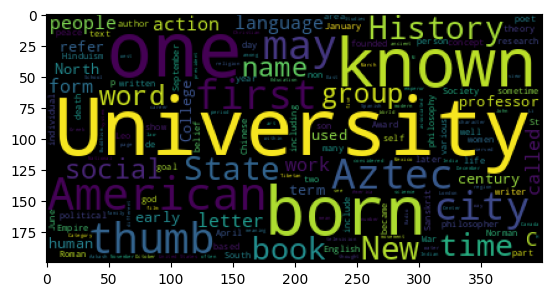

In [87]:
from wordcloud import WordCloud, STOPWORDS

cloud_et = WordCloud(stopwords=STOPWORDS).generate(get_top_abstracts(nodes_en_with_centrality, synthetically_central_nodes_en))
plt.imshow(cloud_et)

In [71]:
nodes_en_with_centrality[nodes_en_with_centrality["node_name"] == "Philosophy"]["node_summary"].values[0]


"thumb|upright=1. 35|The School of Athens (1509–1511) by Raphael, depicting famous classical Greek philosophers in an idealized setting inspired by ancient Greek architecture  Philosophy (from , ) is the systematized study of general and fundamental questions, such as those about existence, reason, knowledge, values, mind, and language.  Some sources claim the term was coined by Pythagoras ( BCE), although this theory is disputed by some. Jaeger, W.  'On the Origin and Cycle of the Philosophic Ideal ."

In [19]:
!pwd

/home/eeriksp/Develop/ut/netsci-wikipedia/notebooks
